# K-Modes Clustering Survey Data

In this notebook wre will use K-Modes clustering as opposed to K-Means, because it will work better with our fundamentially binary data as all one-hot encoded.

### Installation & Set up

`!pip install kmodes`

`!pip install mca`

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import mca
from sklearn.ensemble import RandomForestClassifier

from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
%matplotlib inline

### First define some helper functions (these copied from the `initial_eda_and_feature_engineering.ipynb` notebook)

In [2]:
def age_ranges(x):
    "To be called through Pandas Apply, to map an Age integer to a binned string"
    res = "Unknown"
    if x < 18: res = "Adolescent"
    if x >= 18 and x < 40: res = "Adult"
    if x >= 40 and x < 60: res = "Middle aged"
    if x >= 60 and x < 70: res = "Senior citizens"
    if x >= 71: res = "Elderly"
    return res

def load_data(cols=[]):
    "Perform all the preprocessing steps we identified in the initial_eda_and_feature_engineering.ipynb notebook"
    df = pd.read_csv('survey.csv')

    # So it seems Gender was a free text field and as such is pretty noise. But every row has a value, which is good. There are some obvious fixes:
    # Male, male, M, m, Make, Male (with a space at the end), msle, Mail, Malr, maile, Mal, Cis Male, cis male, Cis Man, Male (CIS) are all 'M'
    # Female, female, F, f, Woman, Female (with a space at the end), femail, Femake, woman, Female (cis), cis-female/femme, Cis Female are all 'F'
    # For simplicity of this exercise I will group all others as 'Other'
    # NOTE: I am a strong supporter of LGBTQ+ rights and such please do not consider this simplification above as anything more for demonstration purposes for this project.
    for gender in ['Male', 'male', 'M', 'm', 'Make', 'Male ', 'msle', 'Mail', 'Malr', 'maile', 'Mal', 'Cis Male', 'cis male', 'Cis Man', 'Male (CIS)', 'Man']:
        df.loc[df['Gender'] == gender, 'Gender'] = 'Male'

    for gender in ['Female', 'female', 'F', 'f', 'Woman', 'Female ', 'femail', 'Femake', 'woman', 'Female (cis)', 'cis-female/femme', 'Cis Female']:
        df.loc[df['Gender'] == gender, 'Gender'] = 'Female'

    df['Gender'] = df['Gender'].apply(lambda x: 'Other' if x not in ['Male', 'Female'] else x)
    
    # A quick look at `comments` shows some interesting info there that could be used in a follow up experiment, but for now I will disregard the `comments` field.
    df.drop('comments', axis=1, inplace=True)

    # Let's look at 'state' first:
    # OK that largely makes sense, right, that the countries are non-US and so seemingly in this data are not using State or a State equivalent.
    # For simplicity lets fill the `nan` US ones with 'CA'.
    df.loc[(df['state'].isna()) & (df['Country'] == 'United States'), 'state'] = df['state'].mode()[0]

    # And set the rest (non-US) to 'N/A'

    df['state'] = df['state'].fillna("N/A")

    # Good, ok let's move on to `self employed`.
    # Interestingly the 18 records that do not have `self_employed` filled are the first 18 in the data_set, so maybe this was not asked fromt eh start.
    # Let's just set them to the mode of the `self_employed` column.
    df.loc[df['self_employed'].isna(), 'self_employed'] = df['self_employed'].mode()[0]

    # So finally, let's look at `work_interfere`.
    # It seems the middle of the road value of 'Sometimes' was the most answer, so let's just use that.
    df.loc[df['work_interfere'].isna(), 'work_interfere'] = df['work_interfere'].mode()[0]

    # Let's bin Age into something categorical.
    df['Age'] = df['Age'].apply(age_ranges)

    # Finally I think we can lose the `TimeStamp'.
    df.drop('Timestamp', axis=1, inplace=True)

    # Filter to just the selected columns
    if len(cols) > 0: df = df[cols]
    
    # separate continuous and categorical variable columns
    # (Although this is boilerplate I use and not really relevant as we have binned the only numerical column ('Age'))
    continuous_vars = [col for col in df.columns if df[col].dtype != 'object']
    categorical_vars = [col for col in df.columns if df[col].dtype == 'object']
    
    if len(continuous_vars) > 0:
        # Scaling is important for K-Means because K-Means is a distance-based algorithm that clusters data points based on their Euclidean distance from a centroid. If the features in the dataset are not scaled, some of them may be given higher weights than others, which can result in clustering biases towards features with larger magnitudes. This can lead to poor cluster assignments and reduced accuracy
        scaler = MinMaxScaler()
        df_con[continuous_vars] = pd.DataFrame(scaler.fit_transform(df[continuous_vars]))
    else:
        df_con = pd.DataFrame()
    
    if len(categorical_vars) > 0:
        df_cat = pd.get_dummies(df, columns=categorical_vars)
    else:
        df_cat = pd.DataFrame()
        
    df_preprocessed = pd.concat([df_con, df_cat], axis=1)
    
    return df, df_preprocessed

### And then some others

In [3]:
def show_clusters(df, col='predicted_cluster'):
    "Simply output the contents of the dataframe per Cluster to see those grouped together"
    for cluster_number in range(len(df[col].unique())):

        idx = df[df[col] == cluster_number].index

        print('Cluster', str(cluster_number))
        display(df.iloc[idx])
        print('---------------')

In [4]:
def get_important_features(df_preprocessed):
    """
    In an attempt to get the most important features identified, let's use a Random Forest classifier.
    We will pass in the training data with the proposed clusters as the labels, which when the model is trained
    the feature importance should be insightful as to how it trained to those labels aka Clusters.
    """
    # Train Random Forest classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(df_preprocessed.drop('predicted_cluster', axis=1), df_preprocessed['predicted_cluster'])

    # Get feature importances
    importances = rf.feature_importances_

    # Sort feature importances in descending order
    sorted_indices = importances.argsort()[::-1]

    # Get sorted feature names and importances
    sorted_features = [df_preprocessed.columns[i] for i in sorted_indices]
    sorted_importances = [importances[i] for i in sorted_indices]

#     for feature, importance in zip(sorted_features[:10], sorted_importances[:10]):
#         print(f"{feature}: {importance}")

    # Plot feature importances as horizontal bar chart
    plt.barh(range(10), sorted_importances[:10], align='center')
    plt.yticks(range(10), sorted_features[:10])
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.show()

### Then load the data and limit to the questions we want

In [5]:
df, df_preprocessed = load_data()

### Elbow method to select k

The 'elbow' of the curve indicates the best number of clusters.

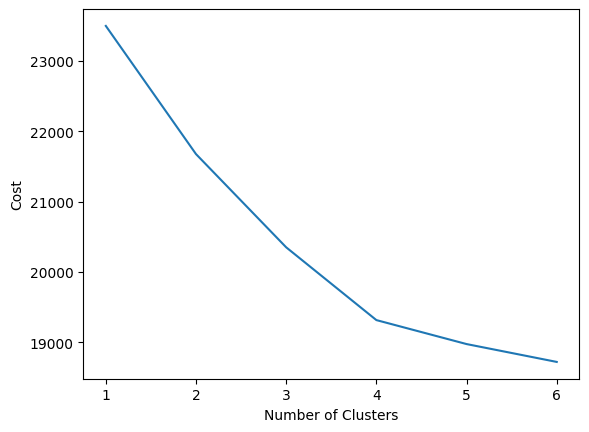

In [6]:
cost = []
K = range(1,7)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init="random", n_init=5)
    kmode.fit_predict(df_preprocessed)
    cost.append(kmode.cost_)
    
plt.plot(K, cost)
plt.xlabel("Number of Clusters")
plt.ylabel('Cost')
plt.show()

Then find the elbow (where the slope declines and it begins to level off).

To determine the elbow point programatically, you can analyze the rate of change in the slope of the curve. One approach is to calculate the second derivative of the curve, which measures the curvature of the curve at each point. The elbow point can be determined as the point with the maximum distance from the line connecting the first and last points of the curve.

In [7]:
# Calculate the second derivative of the curve
cost = np.array(cost)
diff1 = np.diff(cost)
diff2 = np.diff(diff1)
diff2 = np.insert(diff2, 0, 0)

optimal_K = np.argmax(diff2) + 1
print(f"{optimal_K}")

4


### Build the model

In [8]:
# Building the model with 'optimal_K' clusters
kmode = KModes(n_clusters=optimal_K, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(df_preprocessed)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 423, cost: 20196.0
Run 1, iteration: 2/100, moves: 128, cost: 20141.0
Run 1, iteration: 3/100, moves: 29, cost: 20141.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 420, cost: 20091.0
Run 2, iteration: 2/100, moves: 163, cost: 20024.0
Run 2, iteration: 3/100, moves: 79, cost: 19968.0
Run 2, iteration: 4/100, moves: 10, cost: 19968.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 482, cost: 20089.0
Run 3, iteration: 2/100, moves: 149, cost: 20020.0
Run 3, iteration: 3/100, moves: 39, cost: 20020.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 489, cost: 20190.0
Run 4, iteration: 2/100, moves: 177, cost: 19987.0
Run 4, iteration: 3/100, moves: 35, cost: 19987.0
Init: initializing cen

array([3, 1, 2, ..., 0, 2, 0], dtype=uint16)

In [9]:
df_preprocessed.insert(0, "predicted_cluster", clusters, True)
df_preprocessed

,predicted_cluster,Age_Adolescent,Age_Adult,Age_Elderly,Age_Middle aged,Age_Senior citizens,Gender_Female,Gender_Male,Gender_Other,Country_Australia,...,mental_health_interview_No,mental_health_interview_Yes,phys_health_interview_Maybe,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Don't know,mental_vs_physical_No,mental_vs_physical_Yes,obs_consequence_No,obs_consequence_Yes
0,3,False,True,False,False,False,True,False,False,False,...,True,False,True,False,False,False,False,True,True,False
1,1,False,False,False,True,False,False,True,False,False,...,True,False,False,True,False,True,False,False,True,False
2,2,False,True,False,False,False,False,True,False,False,...,False,True,False,False,True,False,True,False,True,False
3,0,False,True,False,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,True
4,1,False,True,False,False,False,False,True,False,False,...,False,True,False,False,True,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2,False,True,False,False,False,False,True,False,False,...,True,False,False,True,False,True,False,False,True,False
1255,0,False,True,False,False,False,False,True,False,False,...,True,False,False,True,False,False,False,True,True,False
1256,0,False,True,False,False,False,False,True,False,False,...,True,False,False,True,False,False,True,False,True,False
1257,2,False,False,False,True,False,True,False,False,False,...,True,False,False,True,False,False,True,False,True,False


OK so now can we visualise the clusters with MCA

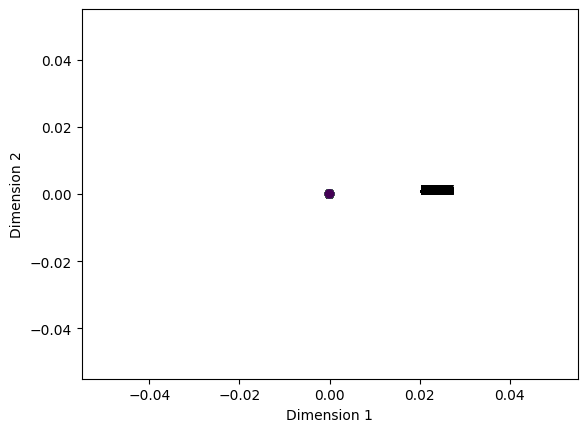

In [10]:
# Perform MCA
df_mca = mca.MCA(df_preprocessed, ncols=3)
mca_results = df_mca.fs_r(N=len(df_preprocessed))

# View the eigenvalues 
# print(df_mca.L) 

# Plot the results 
plt.scatter(mca_results[:,0], mca_results[:,1], c=df_preprocessed['predicted_cluster'].to_list())
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

for label, x, y in zip(df_preprocessed.index, mca_results[:,0], mca_results[:,1]):
    plt.annotate(label, xy=(x, y), xytext=(x + .02, y))

plt.show()

In [11]:
show_clusters(df_preprocessed)

Cluster 0


,predicted_cluster,Age_Adolescent,Age_Adult,Age_Elderly,Age_Middle aged,Age_Senior citizens,Gender_Female,Gender_Male,Gender_Other,Country_Australia,...,mental_health_interview_No,mental_health_interview_Yes,phys_health_interview_Maybe,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Don't know,mental_vs_physical_No,mental_vs_physical_Yes,obs_consequence_No,obs_consequence_Yes
3,0,False,True,False,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,True
6,0,False,True,False,False,False,True,False,False,False,...,True,False,False,True,False,True,False,False,True,False
8,0,False,False,False,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,True,False
10,0,False,True,False,False,False,False,True,False,False,...,True,False,False,True,False,True,False,False,True,False
12,0,False,False,False,True,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,0,False,True,False,False,False,False,True,False,False,...,True,False,True,False,False,False,True,False,True,False
1253,0,False,True,False,False,False,False,True,False,False,...,True,False,False,True,False,True,False,False,True,False
1255,0,False,True,False,False,False,False,True,False,False,...,True,False,False,True,False,False,False,True,True,False
1256,0,False,True,False,False,False,False,True,False,False,...,True,False,False,True,False,False,True,False,True,False


---------------
Cluster 1


,predicted_cluster,Age_Adolescent,Age_Adult,Age_Elderly,Age_Middle aged,Age_Senior citizens,Gender_Female,Gender_Male,Gender_Other,Country_Australia,...,mental_health_interview_No,mental_health_interview_Yes,phys_health_interview_Maybe,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Don't know,mental_vs_physical_No,mental_vs_physical_Yes,obs_consequence_No,obs_consequence_Yes
1,1,False,False,False,True,False,False,True,False,False,...,True,False,False,True,False,True,False,False,True,False
4,1,False,True,False,False,False,False,True,False,False,...,False,True,False,False,True,True,False,False,True,False
5,1,False,True,False,False,False,False,True,False,False,...,True,False,True,False,False,True,False,False,True,False
9,1,False,True,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,True,True,False
11,1,False,True,False,False,False,False,True,False,False,...,False,True,False,False,True,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,1,False,False,False,True,False,False,True,False,False,...,False,True,False,False,True,True,False,False,True,False
1234,1,False,True,False,False,False,False,False,True,False,...,True,False,True,False,False,True,False,False,True,False
1236,1,False,False,False,False,True,False,True,False,False,...,True,False,True,False,False,True,False,False,True,False
1242,1,False,True,False,False,False,False,True,False,False,...,True,False,True,False,False,True,False,False,True,False


---------------
Cluster 2


,predicted_cluster,Age_Adolescent,Age_Adult,Age_Elderly,Age_Middle aged,Age_Senior citizens,Gender_Female,Gender_Male,Gender_Other,Country_Australia,...,mental_health_interview_No,mental_health_interview_Yes,phys_health_interview_Maybe,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Don't know,mental_vs_physical_No,mental_vs_physical_Yes,obs_consequence_No,obs_consequence_Yes
2,2,False,True,False,False,False,False,True,False,False,...,False,True,False,False,True,False,True,False,True,False
7,2,False,True,False,False,False,False,True,False,False,...,True,False,False,True,False,False,True,False,True,False
16,2,False,True,False,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,True,False
19,2,False,True,False,False,False,False,True,False,False,...,False,False,True,False,False,True,False,False,True,False
21,2,False,True,False,False,False,False,True,False,False,...,True,False,True,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241,2,False,True,False,False,False,False,True,False,False,...,True,False,False,True,False,True,False,False,True,False
1244,2,False,True,False,False,False,True,False,False,False,...,True,False,False,False,True,False,True,False,True,False
1247,2,False,True,False,False,False,False,True,False,False,...,True,False,True,False,False,True,False,False,False,True
1254,2,False,True,False,False,False,False,True,False,False,...,True,False,False,True,False,True,False,False,True,False


---------------
Cluster 3


,predicted_cluster,Age_Adolescent,Age_Adult,Age_Elderly,Age_Middle aged,Age_Senior citizens,Gender_Female,Gender_Male,Gender_Other,Country_Australia,...,mental_health_interview_No,mental_health_interview_Yes,phys_health_interview_Maybe,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Don't know,mental_vs_physical_No,mental_vs_physical_Yes,obs_consequence_No,obs_consequence_Yes
0,3,False,True,False,False,False,True,False,False,False,...,True,False,True,False,False,False,False,True,True,False
18,3,False,False,False,True,False,False,True,False,False,...,True,False,False,False,True,False,False,True,False,True
24,3,False,True,False,False,False,False,True,False,False,...,True,False,False,False,True,True,False,False,True,False
27,3,False,True,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,True,True,False
33,3,False,False,False,True,False,False,True,False,False,...,False,False,False,False,True,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,3,False,True,False,False,False,False,True,False,False,...,False,True,False,False,True,False,False,True,True,False
1238,3,False,True,False,False,False,False,True,False,False,...,True,False,False,True,False,False,True,False,False,True
1245,3,False,True,False,False,False,False,True,False,True,...,True,False,True,False,False,True,False,False,False,True
1249,3,False,True,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,True,True,False


---------------


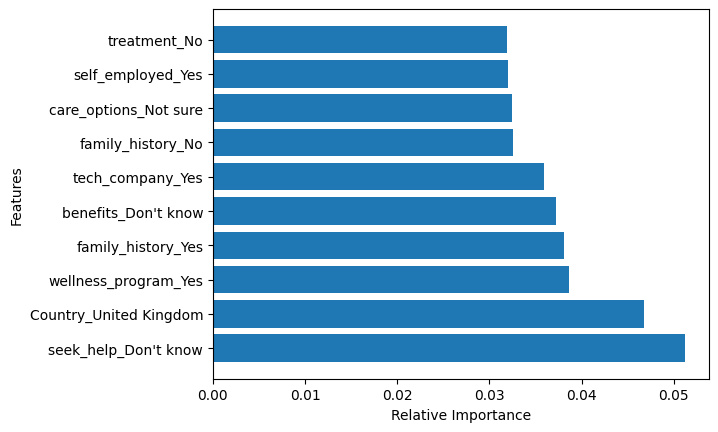

In [12]:
get_important_features(df_preprocessed)

## Disappointing :-(

After a lot of experimenting with K-Modes  I couldn't get near what I wanted.

So let's try something else.

### Let's try Latent Class Analysis in the next Notebook